In [1]:
!pip install pretty-midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 97.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 6.7 MB/s eta 0:00:00
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=571fc6bacf61620cf1a52c0242155324ef706086f315aa0b33b698a83836707a
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty-midi


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from diffusers import UNet2DModel, DDPMScheduler
from matplotlib import pyplot as plt
from pretty_midi import PrettyMIDI, Instrument, Note
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchvision.transforms import RandomAffine
import urllib.request

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from IPython.display import clear_output

In [4]:
target_dir = 'bach-cello'
os.makedirs(target_dir, exist_ok=True)

urls = [
    "cs1-1pre.mid","cs1-2all.mid","cs1-3cou.mid","cs1-4sar.mid","cs1-5men.mid","cs1-6gig.mid",
    "cs2-1pre.mid","cs2-2all.mid","cs2-3cou.mid","cs2-4sar.mid","cs2-5men.mid","cs2-6gig.mid",
    "cs3-1pre.mid","cs3-2all.mid","cs3-3cou.mid","cs3-4sar.mid","cs3-5bou.mid","cs3-6gig.mid",
    "cs4-1pre.mid","cs4-2all.mid","cs4-3cou.mid","cs4-4sar.mid","cs4-5bou.mid","cs4-6gig.mid",
    "cs5-1pre.mid","cs5-2all.mid","cs5-3cou.mid","cs5-4sar.mid","cs5-5gav.mid","cs5-6gig.mid",
    "cs6-1pre.mid","cs6-2all.mid","cs6-3cou.mid","cs6-4sar.mid","cs6-5gav.mid","cs6-6gig.mid",
    'vs1-1ada.mid','vs1-2fug.mid', 'vs1-3sic.mid', 'vs1-4prs.mid', 'vp1-1al.mid', 'vp1-2ald.mid',
    'vp1-3co.mid', 'vp1-4cod.mid', 'vp1-5sa.mid', 'vp1-6sad.mid', 'vp1-7tb.mid', 'vp1-8tbd.mid',
    'vs2-1gra.mid', 'vs2-2fug.mid', 'vs2-3and.mid', 'vs2-4alg.mid', 'vp2-1all.mid', 'vp2-2cou.mid',
    'vp2-3sar.mid', 'vp2-4gig.mid', 'vp2-5cha.mid', 'vs3-1ada.mid', 'vs3-2fug.mid', 'vs3-3lar.mid',
    'vs3-4alg.mid', 'vp3-1pre.mid', 'vp3-2lou.mid', 'vp3-3gav.mid', 'vp3-4min.mid', 'vp3-5bou.mid',
    'vp3-6gig.mid'
]
base_url = "http://www.jsbach.net/midi"

for file in tqdm(urls):
    url = f"{base_url}/{file}"
    file_path = os.path.join(target_dir, file)
    try:
        urllib.request.urlretrieve(url, file_path)
    except Exception as e:
        print(f"Failed to download {file}: {e}")

print("🚀 Done downloading all files!")

  0%|          | 0/67 [00:00<?, ?it/s]

🚀 Done downloading all files!


In [5]:
def midi_to_pianoroll(midi_path, fs=8, pitch_range=(21, 109), max_len=1000):
    try:
        midi = PrettyMIDI(midi_path)
        piano_roll = midi.get_piano_roll(fs=fs)[pitch_range[0]:pitch_range[1]]
        piano_roll = (piano_roll > 0).astype(np.float32)
        if piano_roll.shape[1] < max_len:
            padded = np.zeros((pitch_range[1] - pitch_range[0], max_len))
            padded[:, :piano_roll.shape[1]] = piano_roll
        else:
            padded = piano_roll[:, :max_len]
        return padded.T
    except Exception as e:
        print(f"Error processing {midi_path}: {e}")
        return None

In [6]:
midi_dir = "bach-cello"
data = []

for fname in os.listdir(midi_dir):
    if fname.endswith(".mid"):
        roll = midi_to_pianoroll(os.path.join(midi_dir, fname))
        if roll is not None:
            data.append(roll)

data = np.array(data)  # shape: (num_samples, sequence_len, pitch_dim)
np.save("bach_pianorolls.npy", data)
print("✅ Saved piano rolls as numpy array!")

✅ Saved piano rolls as numpy array!


In [7]:
class MusicDataset(Dataset):
    def __init__(self, data):
        self.data = data.astype(np.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [8]:
class MusicVAE(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=256, latent_dim=32, seq_len=100):
        super(MusicVAE, self).__init__()
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(seq_len * input_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, hidden_dim)
        self.decoder_out = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_dim, seq_len * input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        return self.decoder_out(h).view(-1, self.seq_len, self.input_dim)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

In [9]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld

In [10]:
def train_vae(model, dataloader, epochs=50, lr=1e-3, plot_graph=True):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    loss_history = []
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for batch in dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(batch)
            loss = vae_loss(recon_batch, batch, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        loss_history.append(total_loss / len(dataloader.dataset))
        if epoch % 10 == 9:
            clear_output(wait=True)
            print(f'Epoch {epoch + 1}, Loss: {total_loss / len(dataloader.dataset):.4f}')
            plt.plot(range(epoch+1), loss_history, label='VAE Loss')
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("VAE Training Loss")
            plt.legend()
            plt.grid(True)
            plt.show()

In [11]:
def generate_music(model, num_samples=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim).to(device)
        samples = model.decode(z)
        return samples.cpu().numpy()

In [12]:
data = np.load("bach_pianorolls.npy")
model = MusicVAE(input_dim=88, seq_len=1000)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
dataset = MusicDataset(data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [15]:
model = model.to(device)

Epoch 1000, Loss: 66.2924


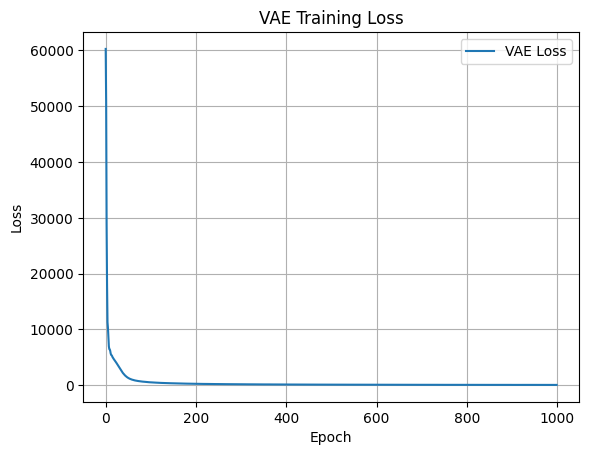

In [16]:
train_vae(model, dataloader, epochs=1000)
samples = generate_music(model)

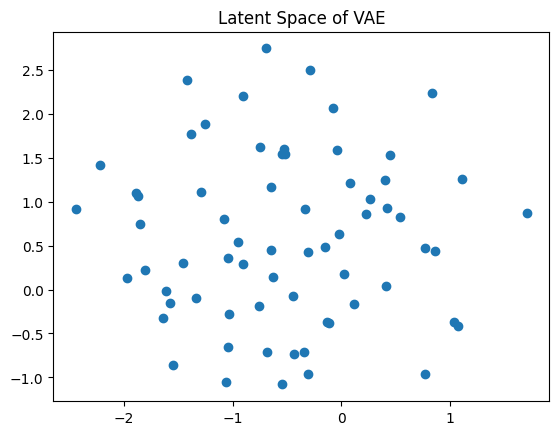

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.eval()
latents = []
for x in dataloader:
    x = x.to(device)
    mu, _ = model.encode(x)
    latents.append(mu.cpu().detach().numpy())
latents = np.concatenate(latents)

tsne = TSNE(n_components=2)
embeddings = tsne.fit_transform(latents)
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("Latent Space of VAE")
plt.show()

In [18]:
def pianoroll_to_midi(piano_roll, fs=8, program=0, pitch_range=(21, 109)):
    pr = piano_roll.T  # (pitch, time)
    midi = PrettyMIDI()
    instrument = Instrument(program=program)
    piano_roll_bin = (pr > 0.5).astype(np.int32)

    for pitch in range(piano_roll_bin.shape[0]):
        onsets = np.where(np.diff(np.pad(piano_roll_bin[pitch], (1, 1))) == 1)[0]
        offsets = np.where(np.diff(np.pad(piano_roll_bin[pitch], (1, 1))) == -1)[0]
        for onset, offset in zip(onsets, offsets):
            start = onset / fs
            end = offset / fs
            note = Note(velocity=100, pitch=pitch + pitch_range[0], start=start, end=end)
            instrument.notes.append(note)

    midi.instruments.append(instrument)
    return midi

In [20]:
samples = generate_music(model, num_samples=5)
for i, roll in enumerate(samples):
    midi = pianoroll_to_midi(roll)
    midi.write(f"vae_generated_{i}.mid")

Music seems generally OK, but it features to many pauses, which kills the flow. To battle this, let's adjust loss and decoder architecture.

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class MusicVAE_UP(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=256, latent_dim=32, seq_len=100):
        super(MusicVAE_UP, self).__init__()
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=5, stride=1, padding=2),  # (B, 64, seq_len)
            nn.ReLU(),
            nn.Conv1d(64, 128, 3, padding=1),  # (B, 128, seq_len)
            nn.ReLU()
        )
        self.encoder_rnn = nn.GRU(input_size=128, hidden_size=hidden_dim, batch_first=True, bidirectional=True)

        self.fc_mu = nn.Linear(hidden_dim * 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim * 2, latent_dim)

        # Decoder (GRU-based)
        self.decoder_rnn = nn.GRU(latent_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = x.transpose(1, 2)
        x = self.encoder_cnn(x)
        x = x.transpose(1, 2)
        _, h_n = self.encoder_rnn(x)
        h = torch.cat((h_n[0], h_n[1]), dim=-1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        # Expand latent vector across the sequence length
        z_seq = z.unsqueeze(1).repeat(1, self.seq_len, 1)  # Shape: (batch, seq_len, latent_dim)
        h_seq, _ = self.decoder_rnn(z_seq)
        return self.output_layer(h_seq)  # Shape: (batch, seq_len, input_dim)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


In [46]:
def weighted_bce_kl_loss(recon_x, x, mu, logvar, pos_weight=10.0, kl_weight=1.0):
    bce = F.binary_cross_entropy(recon_x, x, reduction='none')
    weights = torch.where(x == 1, pos_weight, 1.0)
    recon_loss = (bce * weights).sum()
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_weight * kld

In [47]:
def train_vae_UP(model, dataloader, epochs=50, lr=1e-3, plot_graph=True, pos_weight=10.0):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    model.to(device)

    total_loss_history = []
    recon_loss_history = []
    kl_loss_history = []

    for epoch in tqdm(range(epochs)):
        total_loss = 0
        total_recon_loss = 0
        total_kl = 0

        for batch in dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(batch)

            # KL annealing
            kl_weight = min(5.0, epoch / 50.0)

            # Weighted BCE loss
            bce = F.binary_cross_entropy(recon_batch, batch, reduction='none')
            weights = torch.where(batch == 1, pos_weight, 1.0)
            recon_loss = (bce * weights).sum()
            kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
            kl = torch.maximum(kl, torch.full_like(kl, 0.5)).sum()
            loss = recon_loss + kl_weight * kl

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl += kl.item()

        total_loss_history.append(total_loss / len(dataloader.dataset))
        recon_loss_history.append(total_recon_loss / len(dataloader.dataset))
        kl_loss_history.append(total_kl / len(dataloader.dataset))

        if plot_graph and epoch % 10 == 9:
            clear_output(wait=True)
            print(f"Epoch {epoch + 1} | Recon Loss: {total_recon_loss:.2f} | KL: {total_kl:.2f} | KL Weight: {kl_weight:.2f}")

            fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
            axs[0].plot(range(1, epoch + 2), recon_loss_history, label='Reconstruction Loss', color='blue')
            axs[0].set_ylabel("Reconstruction Loss")
            axs[0].legend()
            axs[0].grid(True)

            axs[1].plot(range(1, epoch + 2), kl_loss_history, label='KL Divergence', color='red')
            axs[1].set_xlabel("Epoch")
            axs[1].set_ylabel("KL Divergence")
            axs[1].legend()
            axs[1].grid(True)

            plt.suptitle("VAE Loss Components Over Epochs")
            plt.tight_layout()
            plt.show()



In [48]:
model = MusicVAE_UP(input_dim=88, seq_len=1000).to(device)

Epoch 1000 | Recon Loss: 1339252.21 | KL: 2284.98 | KL Weight: 5.00


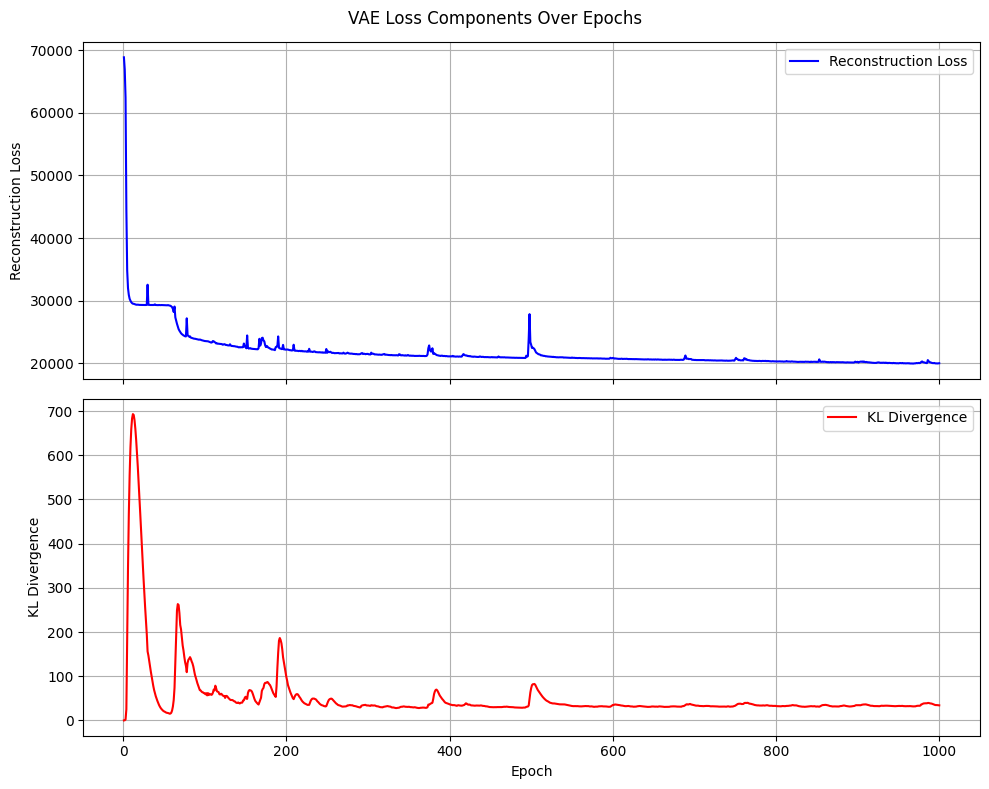

100%|██████████| 1000/1000 [05:37<00:00,  2.96it/s]


In [49]:
train_vae_UP(model, dataloader, epochs=1000)

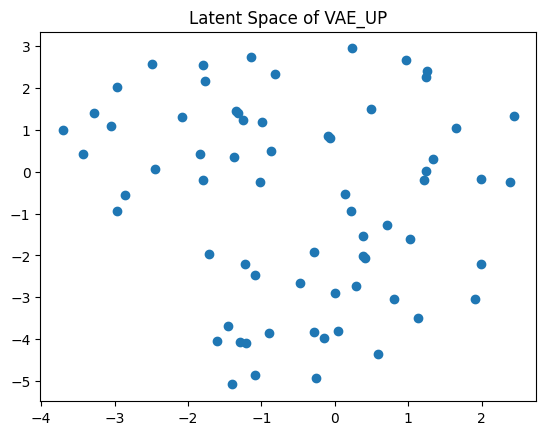

In [50]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.eval()
latents = []
for x in dataloader:
    x = x.to(device)
    mu, _ = model.encode(x)
    latents.append(mu.cpu().detach().numpy())
latents = np.concatenate(latents)

tsne = TSNE(n_components=2)
embeddings = tsne.fit_transform(latents)
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("Latent Space of VAE_UP")
plt.show()

In [51]:
samples = generate_music(model, num_samples=5)
for i, roll in enumerate(samples):
    midi = pianoroll_to_midi(roll)
    midi.write(f"vae_up_generated_{i}.mid")

Decoder too strong, now model basically ignores the latent space and generates almost empty files :)

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class MusicVAE_UP(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=256, latent_dim=32, seq_len=100):
        super(MusicVAE_UP, self).__init__()
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=5, stride=1, padding=2),  # (B, 64, seq_len)
            nn.ReLU(),
            nn.Conv1d(64, 128, 3, padding=1),  # (B, 128, seq_len)
            nn.ReLU()
        )
        self.encoder_rnn = nn.GRU(input_size=128, hidden_size=hidden_dim, batch_first=True, bidirectional=True)

        self.fc_mu = nn.Linear(hidden_dim * 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim * 2, latent_dim)

        self.decoder_mlp = nn.Sequential(
          nn.Linear(latent_dim, 512),
          nn.ReLU(),
          nn.Linear(512, self.seq_len * self.input_dim),
          nn.Sigmoid()
      )

    def encode(self, x):
        x = x.transpose(1, 2)
        x = self.encoder_cnn(x)
        x = x.transpose(1, 2)
        _, h_n = self.encoder_rnn(x)
        h = torch.cat((h_n[0], h_n[1]), dim=-1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        out = self.decoder_mlp(z)
        return out.view(-1, self.seq_len, self.input_dim)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


In [56]:
model = MusicVAE_UP(input_dim=88, seq_len=1000).to(device)

Epoch 1000 | Recon Loss: 4098.90 | KL: 3757.01 | KL Weight: 5.00


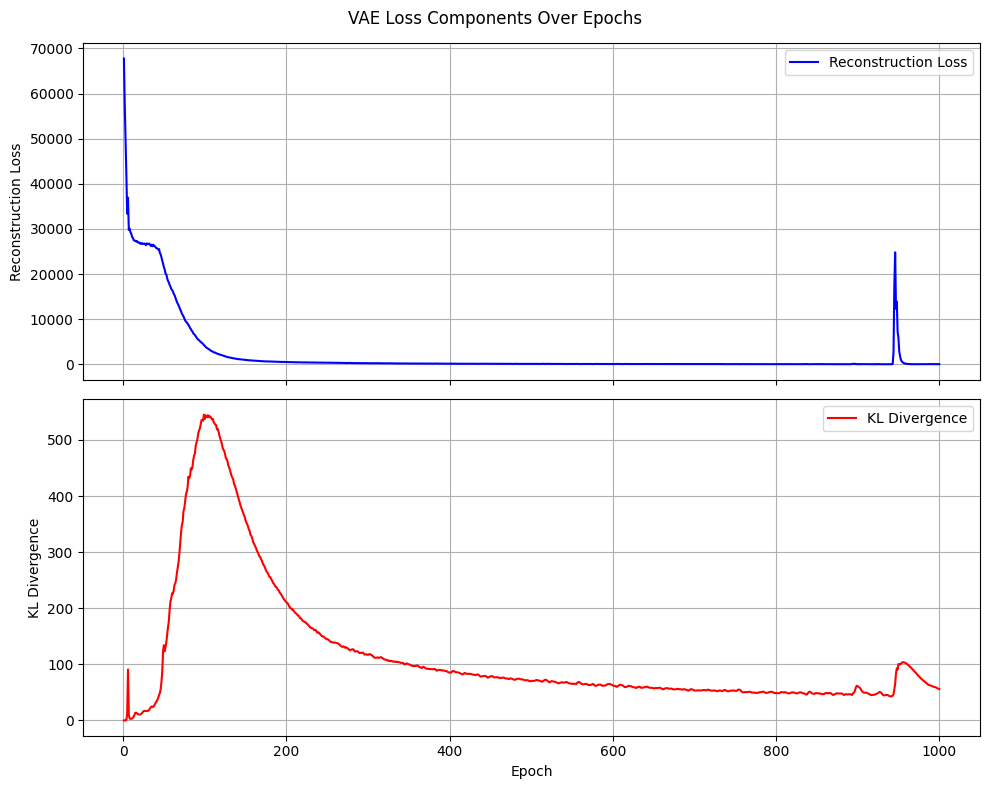

100%|██████████| 1000/1000 [04:25<00:00,  3.76it/s]


In [57]:
train_vae_UP(model, dataloader, epochs=1000)

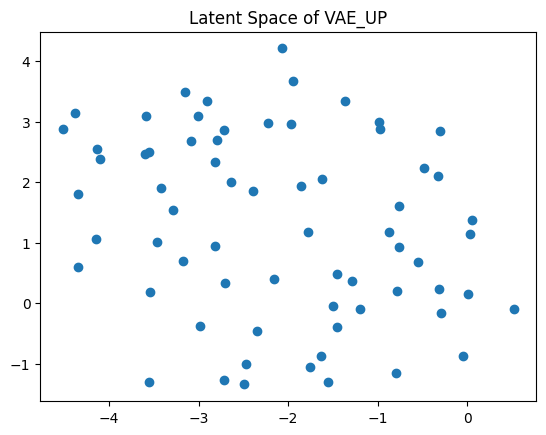

In [58]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.eval()
latents = []
for x in dataloader:
    x = x.to(device)
    mu, _ = model.encode(x)
    latents.append(mu.cpu().detach().numpy())
latents = np.concatenate(latents)

tsne = TSNE(n_components=2)
embeddings = tsne.fit_transform(latents)
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("Latent Space of VAE_UP")
plt.show()

In [59]:
samples = generate_music(model, num_samples=5)
for i, roll in enumerate(samples):
    midi = pianoroll_to_midi(roll)
    midi.write(f"vae_up_down_generated_{i}.mid")

Results are much better, now it doesn't suffer from abruptive pauses